<a href="https://colab.research.google.com/github/asrorKholmatov/ML-Engineer-Portfolio/blob/main/Audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asrorxolmatov
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


100%|██████████| 2.12G/2.12G [00:22<00:00, 100MB/s]


In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import librosa
from skimage.transform import resize

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
data_df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv") # Read the original csv as a dataframe

data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset/' + data_df['FilePath'].str[1:] # Modify the paths in the dataframe


data_df.head() # Visualize the first 5 rows


,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


In [ ]:
print("Data shape: ", data_df.shape)
print("Class Distribution: ", data_df["Class"].value_counts())


Data shape:  (6687, 2)
Class Distribution:  Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64


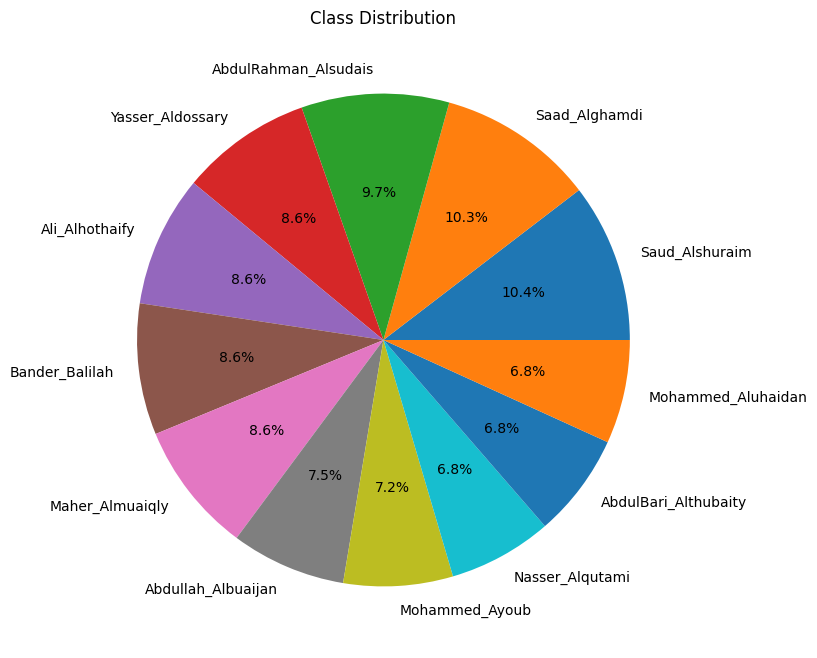

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(data_df['Class'].value_counts(), labels = data_df['Class'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

In [ ]:
label_encoder = LabelEncoder()
data_df['Class'] = label_encoder.fit_transform(data_df['Class'])

train = data_df.sample(frac=0.7, random_state=7)
test = data_df.drop(train.index)

val = test.sample(frac = 0.5, random_state=7)
test = test.drop(val.index)

print("Train shape: ",train.shape)
print("Val shape: ",val.shape)
print("Test shape: ",test.shape)

Train shape:  (4681, 2)
Val shape:  (1003, 2)
Test shape:  (1003, 2)


In [ ]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.labels = torch.Tensor(list(dataframe['Class'])).type(torch.LongTensor).to(device)
        self.audio = [torch.Tensor(self.get_spectogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = torch.Tensor(self.labels[idx]).to(device)
        audio = self.audio[idx].unsqueeze(0)
        return audio, label

    def get_spectogram(self, file_path):
        sr = 22050
        duration = 5
        img_height = 128
        img_width = 256

        signal, sr = librosa.load(file_path, sr=sr, duration = duration)
        spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels = 128)
        spec_db = librosa.power_to_db(spec, ref=np.max)

        spec_resized = librosa.util.fix_length(spec_db, size=(duration*sr) // 512+1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)

        return spec_resized

In [ ]:
train_dataset = CustomAudioDataset(dataframe = train)
val_dataset = CustomAudioDataset(dataframe = val)
test_dataset = CustomAudioDataset(dataframe = test)

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 15

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
num_classes = len(data_df['Class'].unique())

In [ ]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # 1 → 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 16 → 32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32 → 64
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 32, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
model = Net(num_classes).to(device)
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=1024, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Line

In [ ]:
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
              ReLU-2         [-1, 16, 128, 256]               0
         MaxPool2d-3          [-1, 16, 64, 128]               0
            Conv2d-4          [-1, 32, 64, 128]           4,640
              ReLU-5          [-1, 32, 64, 128]               0
         MaxPool2d-6           [-1, 32, 32, 64]               0
            Conv2d-7           [-1, 64, 32, 64]          18,496
              ReLU-8           [-1, 64, 32, 64]               0
         MaxPool2d-9           [-1, 64, 16, 32]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                 [-1, 4096]     134,221,824
             ReLU-12                 [-1, 4096]               0
          Dropout-13                 [-1, 4096]               0
           Linear-14                 [-

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  start_time = time.time()
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  if epoch % 5 == 0:
    epoch_string = f"""
                    Epoch: {epoch+5}/{EPOCHS},
                    Train Loss: {round(total_loss_train/100, 4)},
                    Train Accuracy: {round((total_acc_train/train_dataset.__len__() * 100), 4)},
                    Validation Loss: {round(total_loss_val/100, 4)},
                    Validation Accuracy: {round((total_acc_val/val_dataset.__len__() * 100), 4)}
                    """
    print(epoch_string)
    print("="*30)


                    Epoch: 5/15, 
                    Train Loss: 7.2789, 
                    Train Accuracy: 11.8992, 
                    Validation Loss: 1.4779, 
                    Validation Accuracy: 19.342
                    

                    Epoch: 10/15, 
                    Train Loss: 0.188, 
                    Train Accuracy: 98.2482, 
                    Validation Loss: 0.0792, 
                    Validation Accuracy: 96.2114
                    

                    Epoch: 15/15, 
                    Train Loss: 0.1011, 
                    Train Accuracy: 99.1455, 
                    Validation Loss: 0.0871, 
                    Validation Accuracy: 96.012
                    


In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    prediction = model(inputs)
    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()

    total_acc_test += acc

print(f"Total Accuracy Score is: {(total_acc_test / len(test_dataset)) * 100:.2f}%")
print(f"Total Loss  is: {(total_loss_test / len(test_dataset)) * 100:.2f}%")

Total Accuracy Score is: 97.31%
Total Loss  is: 0.00%


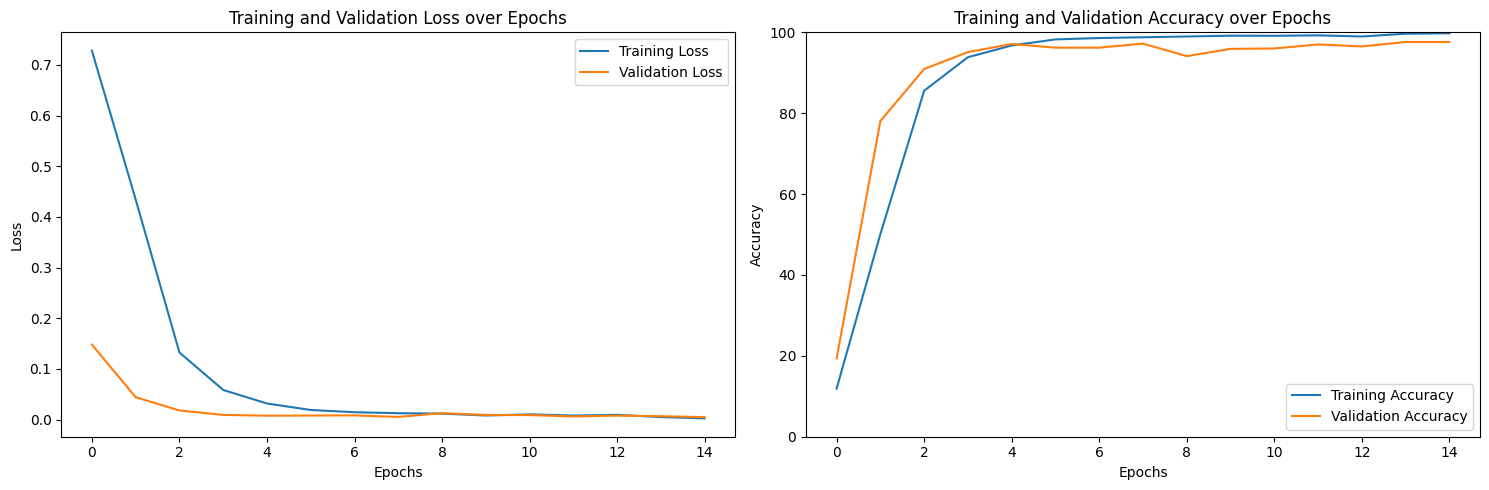

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()